# Assignment 4b - Graph Convolutional Networks
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for many interesting models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [1]:
!nvidia-smi

Fri Dec 23 17:59:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction

Graphs are very useful data structures that allow us to represent sets of entities and the way they are related among each other. In a graph, entities are also known as *nodes*, and any link between entities is also called an *edge*.

Examples of real world objects that can be modeled as graphs are social networks, where entities are people and relations denote friendship; and molecules, where entities are atoms and relations indicate a bond between them.

There has been increased interest in the recent years in the application of deep learning architectures to graph-structured data, for tasks like predicting missing relations between entities, classifying entities, and classifying graphs. This interest has been spurred by the introduction of Graph Convolutional Networks (GCNs).

In this assignment, you will implement and experiment with one of the first versions of the GCN, proposed by Thomas Kipf and Max Welling in their 2017 paper, [Semi-supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). In particular, the goals of this assignment are to

- Understand how GCNs are formulated
- Implement the GCN using PyTorch
- Train and evaluate a model for semi-supervised node classification in citation networks
- Train and evaluate a model for binary classification of molecules

### Representing graphs

Suppose we have the following graph:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/01-graph.png" width="200">

This is an undirected graph (since the edges have no specified direction) with 4 nodes. One way to represent the connectivity structure of the graph is by means of the **adjacency matrix**. The $i$-th row of the matrix contains a 1 in the $j$-th column, if nodes $i$ and $j$ are connected. For an undirected graph like the one above, this means that the adjacency matrix

- Is symmetric (e.g. an edge between 0 and 2 is equivalent as an edge between 2 and 0)
- Is square, of size $n\times n$ where $n$ is the number of nodes

The adjacency matrix for the graph above is then the following:

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 0 \\ 
0 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

A second matrix of interest is the **degree matrix**. This is a diagonal matrix where the $i$-th element of the diagonal indicates the number of edges connected to node $i$. Note that these can be obtained from $A$ by summing across the columns, or the rows. For our example, the degree matrix is

$$
D = \begin{bmatrix}
1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For specific applications, each node in the graph will have an associated vector of features $x\in\mathbb{R}^c$. If our graph is a social network, then the vector of features can contain information like age, location, and musical tastes, in a specific numeric format. In the case of a molecule, the node could represent an atom and have features like the atomic mass, etc. We can lay out the features in a matrix $X\in\mathbb{R}^{n\times c}$, so that the feature vector for node $i$ is in the $i$-th row.

### Loading a citation network

To move to a real world example, we will start with the Cora dataset. This dataset represents a citation network, where nodes are scientific publications, edges denote citations between them, and features are a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) extracted from their contents.

This graph contains labels for nodes, that represent a specific topic. We will use these for a node classification task.

To easily load it, we will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG), a deep learning library for graph-structured data.

In [2]:
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --y
!pip3 install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
import torch
from torch import nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
     |████████████████████████████████| 539 kB 4.8 MB/s 
     |████████████████████████████████| 491 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.5 MB/s 
     |████████████████████████████████| 704 kB 45.9 MB/s 
     |████████████████████████████████| 202 kB 62.7 MB/s 
     |████████████████████████████████| 564 kB 4.5 MB/s 
     |████████████████████████████████| 280 kB 55.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=9ef92d6d59413fdb471258bd6921070fc8365c2081ae434045ad7c89d4b85543
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Success

We can now use the library to download and import the dataset. Initializing the `Planetoid` class returns a `Dataset` object that can contain multiple graphs. In this task we will only use the `Cora` dataset (the citation network) and hence, we will select only the first element.

In [3]:
from torch_geometric.datasets import Planetoid

data = Planetoid(root='data/Planetoid', name='Cora')[0]

Processing...
Done!



#### Question 1 (0.25 pt)

The `data` object is an instance of the `Data` class in PyG. Check the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) and report the following properties of the graph:

- Number of nodes
- Number of edges 
- The dimension $c$ of the feature vectors $x\in\mathbb{R}^c$
- The number of targets for the classification task

In [4]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Dimension of feature vectors: {data.num_node_features}")

class_set = set([x.item() for x in data.y])
print(f"Number of targets: {len(class_set)}")


Number of nodes: 2708
Number of edges: 10556
Dimension of feature vectors: 1433
Number of targets: 7


#### Question 2 (0.25 pt)

In PyG, edges are provided in a tensor of shape (2, number of edges). You can access it via `data.edge_index`. Each column in this tensor contains the IDs for two nodes that are connected in the graph.

We saw that in an undirected graph, an edge between nodes $i$ and $j$ adds a value of 1 to positions $(i, j)$ and $(j, i)$ of the adjacency matrix. Is this also true for the edge index? That is, if there is an edge $(i, j)$ in `data.edge_index`, is there also an edge for $(j, i)$? This is important to know for the next steps of the implementation.

In [5]:
transposed = data.edge_index.transpose(0, 1)
test = torch.tensor([0,0])

any((test[0] == transposed[:, 0]) & (test[1] == transposed[:, 1]))

False

In [45]:
# Your answer here
from tqdm import tqdm
symmetry = True

transposed = data.edge_index.transpose(0, 1)
for i in tqdm(range(len(transposed)), leave=False):
  inverted = torch.tensor([transposed[i][1], transposed[i][0]])
  # https://stackoverflow.com/questions/66036375/how-to-check-whether-tensor-values-in-a-different-tensor-pytorch
  if not any((inverted[0] == transposed[:, 0]) & (inverted[1] == transposed[:, 1])):
    symmetry = False
    break

if symmetry:
  print("For every edge (i, j), there is an edge (j, i).")
else:
  print("There is at least one edge (i, j) for which there is no edge (j, i).")
  
  

For every edge (i, j), there is an edge (j, i).


#### Question 3 (0.5 pt)

In graphs, especially large ones, the adjacency matrix is **sparse**: most entries are zero. Sparse matrices allow for efficient storage and computation.

To prepare and pre-process sparse matrices, we will use [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Once the matrices are ready, we will convert them to PyTorch tensors.

We will use the [Sparse COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). We encourage you to first get familiar with how it works after continuing with the assignment.

- Use the [`scipy.sparse.coo_matrix()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to build the adjacency matrix. Think of what arguments are needed, and how you can obtain them from the graph data loaded above.
- Use the `sum()` method of sparse matrices, together with `scipy.sparse.diags()`, to compute the degree matrix using the definition above.

Both resulting matrices must be sparse of type `float32`.

In [7]:
from scipy import sparse
from tqdm import tqdm
import numpy as np

# coo_matrix
matrix = np.zeros([data.num_nodes, data.num_nodes])
transposed = data.edge_index.transpose(0, 1)
for i in range(len(transposed)):
  x, y = transposed[i]
  matrix[x.item()][y.item()] = 1.
cm = sparse.coo_matrix(matrix)
print(cm)

# degree matrix
sums = cm.sum(0, float).A1
dm = sparse.diags(sums, offsets=0)
print(dm.toarray())

  (0, 633)	1.0
  (0, 1862)	1.0
  (0, 2582)	1.0
  (1, 2)	1.0
  (1, 652)	1.0
  (1, 654)	1.0
  (2, 1)	1.0
  (2, 332)	1.0
  (2, 1454)	1.0
  (2, 1666)	1.0
  (2, 1986)	1.0
  (3, 2544)	1.0
  (4, 1016)	1.0
  (4, 1256)	1.0
  (4, 1761)	1.0
  (4, 2175)	1.0
  (4, 2176)	1.0
  (5, 1629)	1.0
  (5, 1659)	1.0
  (5, 2546)	1.0
  (6, 373)	1.0
  (6, 1042)	1.0
  (6, 1416)	1.0
  (6, 1602)	1.0
  (7, 208)	1.0
  :	:
  (2694, 431)	1.0
  (2694, 2695)	1.0
  (2695, 431)	1.0
  (2695, 2694)	1.0
  (2696, 2615)	1.0
  (2697, 986)	1.0
  (2698, 1400)	1.0
  (2698, 1573)	1.0
  (2699, 2630)	1.0
  (2700, 1151)	1.0
  (2701, 44)	1.0
  (2701, 2624)	1.0
  (2702, 186)	1.0
  (2702, 1536)	1.0
  (2703, 1298)	1.0
  (2704, 641)	1.0
  (2705, 287)	1.0
  (2706, 165)	1.0
  (2706, 169)	1.0
  (2706, 1473)	1.0
  (2706, 2707)	1.0
  (2707, 165)	1.0
  (2707, 598)	1.0
  (2707, 1473)	1.0
  (2707, 2706)	1.0
[[3. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ..

You might wonder why we suggest to use a scipy sparse matrix, while also PyTorch supports them. The reason is that in the next step, we will be multiplying two sparse matrices, an operation not supported in PyTorch. PyTorch only allows multiplying a sparse matrix with a dense one, something which we will be doing at a later stage.



### The Graph Convolutional Network

The goal of the graph convolution is to take the feature vectors of all nodes $X\in\mathbb{R}^{n\times c}$, and propagate them along the existing edges, to obtain updated representations $Z\in\mathbb{R}^{n\times d}$.


The GCN is initially motivated as performing a convolution, similarly as it is done in CNNs for images, for graph-structured data. In Kipf and Welling (2017), a theoretical derivation leads to the following formula:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$

where

- $W\in\mathbb{R}^{c\times d}$ is a matrix of parameters to be learned via gradient descent
- $\tilde{A} = A + I_n$, where $I_n$ is an $n\times n$ identity matrix
- $\tilde{D}$ is the degree matrix computed with $\tilde{A}$ as the adjacency matrix

If we define $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, the graph convolution can be written as $Z = \hat{A}XW$.

#### Question 4 (0.25 pt)

Given the formula for the GCN, explain why it operates by propagating feature vectors across the graph. To answer this, it might be useful to recall the definitions of the adjacency and degree matrices, and how they are involved in the formula.

The adjacency matrix $A$ of a graph defines its structure by indicating which pairs of nodes are connected. It is a square matrix with dimensions equal to the number of nodes in the graph, and its entries are either 0 or 1 depending on whether there is an edge between the corresponding pair of nodes.

The degree matrix $\tilde{D}$ is a diagonal matrix with dimensions equal to the number of nodes in the graph, where the $i$-th diagonal entry $\tilde{D}_{i,i}$ is equal to the sum of the $i$-th row of the adjacency matrix $\tilde{A}$. This quantity represents the degree, or number of connections, of node $i$.

The GCN operates by propagating the feature vectors $X$ of all nodes across the graph using the adjacency and degree matrices as "filters". Specifically, the formula for the GCN involves the product $\hat{A}X$, where $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$. This product results in a weighted sum of the feature vectors of the neighbors of each node, with the weights determined by the entries of $\hat{A}$. The entries of $\hat{A}$ are in turn determined by the adjacency and degree matrices, which encode the structure of the graph and the connectivity of the nodes.

Therefore, the GCN operates by propagating the feature vectors of the nodes across the graph by taking into account the structure of the graph and the connectivity of the nodes, as defined by the adjacency and degree matrices.

#### Question 5 (0.5 pt)

Compute the **normalized adjacency matrix** $\hat{A}$. The result should be a sparse matrix.

In [8]:
A = sparse.coo_matrix(cm + np.identity(data.num_nodes))
D = sparse.diags(A.sum(0, float).A1)
A = sparse.linalg.inv(D.sqrt()) * A * sparse.linalg.inv(D.sqrt())
A = A.tocoo()
print(A)

/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  (0, 0)	0.25
  (633, 0)	0.25
  (1862, 0)	0.22360679774997896
  (2582, 0)	0.25
  (1, 1)	0.25
  (2, 1)	0.20412414523193154
  (652, 1)	0.2886751345948129
  (654, 1)	0.35355339059327373
  (1, 2)	0.20412414523193154
  (2, 2)	0.1666666666666667
  (332, 2)	0.1666666666666667
  (1454, 2)	0.2886751345948129
  (1666, 2)	0.1543033499620919
  (1986, 2)	0.050251890762960605
  (3, 3)	0.4999999999999999
  (2544, 3)	0.4999999999999999
  (4, 4)	0.1666666666666667
  (1016, 4)	0.1666666666666667
  (1256, 4)	0.13608276348795434
  (1761, 4)	0.14433756729740646
  (2175, 4)	0.1666666666666667
  (2176, 4)	0.13608276348795434
  (5, 5)	0.25
  (1629, 5)	0.25
  (1659, 5)	0.2886751345948129
  :	:
  (2699, 2699)	0.4999999999999999
  (1151, 2700)	0.408248290463863
  (2700, 2700)	0.4999999999999999
  (44, 2701)	0.2886751345948129
  (2624, 2701)	0.3333333333333334
  (2701, 2701)	0.3333333333333334
  (186, 2702)	0.2182178902359924
  (1536, 2702)	0.25819888974716115
  (2702, 2702)	0.3333333333333334
  (1298, 2703)	0.49

#### Question 6 (0.5 pt)

So far we have used scipy to build and compute sparse matrices. Since we want to train a GCN with PyTorch, we need to convert $\hat{A}$ into a sparse PyTorch tensor. You can do this with the [`torch.sparse_coo_tensor()`](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html) function, making sure to specify `torch.float` as the type.

In [9]:
values = A.data
indices = np.vstack((A.row, A.col))
shape = A.shape

v = torch.FloatTensor(values)
i = torch.Tensor(indices)

A = torch.sparse_coo_tensor(i, v, shape)

print(A)

tensor(indices=tensor([[   0,  633, 1862,  ..., 1473, 2706, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2236,  ..., 0.2000, 0.2000, 0.2000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)


#### Question 7 (0.5 pt)

We now have all the ingredients to build a GCN layer. Implement a class (inheriting from `torch.nn.Module`) with a learnable matrix of weights $W\in\mathbb{R}^{c\times d}$. Make sure to

- Call this class `GCNLayer`
- The `__init__()` constructor should take as argument the number of input and output features.
- Use `torch.nn.init.kaiming_uniform_` to initialize $W$.
- Define the `forward` method, which takes as input $X$ and $\hat{A}$ and returns $Z$. Note that multiplications involving the sparse matrix $\hat{A}$ have to be done with `torch.spmm`. 

Once you have implemented the class, instantiate a layer with the correct number of input features for the Cora dataset, and a number of output features of your choice. Do a forward pass and report the shape of the output tensor.

In [10]:
# Your answer here
class GCNLayer(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.fc = nn.Linear(input, output)
        nn.init.kaiming_uniform_(self.fc.weight)

    def forward(self, X, A):
        Z = torch.spmm(A, X)
        return self.fc(Z)


In [11]:
X = data.x.to_sparse()

gcn = GCNLayer(data.num_node_features, len(data.y.unique()))
outp = gcn(X, A)

print(outp.shape)

torch.Size([2708, 7])


#### Question 8 (0.5 pt)

As we have seen so far, the GCN layer implements a special type of linear transformation of the inputs. However, it is often beneficial in deep learning to stack multiple, non-linear transformations of the input features. Implement a second module class for a model with two GCN layers (use the module you implemented in the previous question).

- Call this class `GCN`
- The constructor must now take as input the number of input features, the output dimension of the first layer (this is the hidden layer), and the output dimension of the output layer.
- In the forward pass, add a ReLU activation function after the first layer.

In [12]:
# Your answer here
import torch.nn.functional as F

class GCN(nn.Module):
  def __init__(self, input, hidden, output):
    super().__init__()
    self.gcn1 = GCNLayer(input, hidden)
    self.gcn2 = GCNLayer(hidden, output)
    self.relu = nn.ReLU()

  def forward(self, X, A):
    x = self.gcn1(X, A)
    x = self.relu(x)
    x = self.gcn2(x, A)
    return x


### GCNs for semi-supervised node classification

Now that we have a GCN with two layers, we can test its performance in a node classification task. We will pass the input node features $X$ through the GCN layers, and the output will be of size $n\times k$ where $k$ is the number of classes (which you found in question 1). The label denotes the topic an article in the citation network belongs to (e.g. physics, computer science, etc.).

#### Question 9 (1.5 pt)

Note that the `data` object contains all labels (for all splits) in `data.y`, and binary masks for the train, validation, and test splits in `data.train_mask`, `data.val_mask`, and `data.test_mask`, respectively. These masks are the same size as `data.y`, and indicate which labels belong to which split.

- Create a GCN with two layers (using the class from the previous question), with 32 as the hidden dimension, and the number of output features equal to the number of classes in the Cora dataset.

- Use the Adam optimizer with a learning rate of 0.01.

- Implement a training loop for the GCN. At each step, pass $X$ and $\hat{A}$ to the GCN to obtain the logits. Compute the mean cross-entropy loss **only for the training instances**, using the binary masks.

- After each training step, evaluate the accuracy for the validation instances.

- Train for 100 epochs. Once training is finished, plot the training loss and validation accuracy (in a graph in function of the epoch number), and report the accuracy in the test set.

You should obtain an accuracy over 75% on both the validation and test sets. You can also compare your results with the original paper, which also contains results for the Cora dataset. Give a brief discussion on the results of your experiments.

Note that in contrast with other tasks, like image classification on some datasets, we don't use mini-batches here. The whole matrix of features and the adjacency is passed to the GCN in one step.

In [13]:
def get_A(data):
  '''Quick helper function to create the A matrix from the data. 
  For when the notebook variables get all mixed up, this will always
  return a clean A matrix for the given data'''
  # Create the A matrix 
  matrix = np.zeros([data.num_nodes, data.num_nodes])
  # Transposed gives the edges as node index pairs
  transposed = data.edge_index.transpose(0, 1)
  for node_pair_idx in range(len(transposed)):
    x, y = transposed[node_pair_idx]
    # Set the entry in the a matix as  1
    matrix[x.item()][y.item()] = 1.
  cm = sparse.coo_matrix(matrix)

  # Also add self-connections
  A = sparse.coo_matrix(cm + np.identity(data.num_nodes))
  # Create degree matix (in-degree of nodes as diagonal)
  D = sparse.diags(A.sum(0, float).A1)
  # Get Â from D * A * D
  A = sparse.linalg.inv(D.sqrt()) * A * sparse.linalg.inv(D.sqrt())
  A = A.tocoo()

  # A sparse tensor is not a full tensor but basically a shape 
  #  with values for given indices
  values = A.data
  indices = np.vstack((A.row, A.col))
  shape = A.shape

  v = torch.FloatTensor(values)
  i = torch.Tensor(indices)

  return torch.sparse_coo_tensor(i, v, shape)

In [42]:
# Your answer here
# Reset the dataset
data = Planetoid(root='data/Planetoid', name='Cora')[0].to(DEVICE)

mdl = GCN(data.num_node_features, 32, len(data.y.unique())).to(DEVICE)

optimizer = torch.optim.Adam(mdl.parameters(), lr=0.001)

# Get the clean A and X matices
A = get_A(data).to(DEVICE)
X = data.x.to_sparse()

# Train the mdl
mdl.train()
for epoch in range(100):
    mdl.train()

    optimizer.zero_grad()
    out = mdl(X,A)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Validate
    mdl.eval()
    loss = F.cross_entropy(out[data.val_mask], data.y[data.val_mask])

    pred = mdl(X, A).argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    acc = int(correct) / int(data.val_mask.sum())

    print(acc)



/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


0.106
0.124
0.144
0.162
0.18
0.23
0.264
0.3
0.348
0.384
0.4
0.416
0.448
0.47
0.484
0.492
0.502
0.508
0.524
0.54
0.554
0.568
0.574
0.582
0.598
0.618
0.624
0.63
0.632
0.64
0.64
0.646
0.654
0.668
0.672
0.678
0.684
0.69
0.696
0.702
0.702
0.702
0.706
0.71
0.714
0.718
0.73
0.736
0.744
0.746
0.746
0.746
0.746
0.746
0.746
0.742
0.744
0.746
0.748
0.748
0.75
0.748
0.75
0.756
0.758
0.758
0.758
0.762
0.762
0.764
0.764
0.768
0.77
0.77
0.77
0.774
0.772
0.772
0.776
0.778
0.778
0.778
0.778
0.78
0.778
0.778
0.778
0.78
0.78
0.78
0.78
0.78
0.78
0.78
0.782
0.782
0.782
0.782
0.782
0.782


In [44]:
# Final test loss and accuracy
mdl.eval()
loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
# print(loss.item())

pred = mdl(X, A).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print("Model test set loss:", loss.item())
print("Model test set accuracy:", acc)

Model test set loss: 0.8208478689193726
Model test set accuracy: 0.791


#### Question 10 (0.5 pt)

The paper introduces GCNs as a way to solve a *semi-supervised* classification problem.

- What makes this problem semi-supervised?
- What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?
- Why do you think the GCN performs well in this semi-supervised scenario?

In [15]:
# Your answer here
torch.sum(data.train_mask) / (torch.sum(data.val_mask) + torch.sum(data.test_mask) + torch.sum(data.train_mask))

tensor(0.0854, device='cuda:0')

**ANSWER**

The problem can be characterised as semi-supervised since we do not have all classes for all nodes extensively. We have some classes for some nodes and from this we are able to create a train, test and validation set making the problem partly supervised. At the same time some nodes in the dataset have classes but they have not been assigned to the nodes yet and as such are in neither the training, test and validation test, making them entirely new findings. As such the problem is semi-supervised. So only a subset is labeled and the dataset contains both labeled and unlabelled examples.

The proportion of training data to validation and test data is only 0.093 (train / val + test) indicating that only 8.5% of the total data is training data. A split with this proportion is very uncommon for training data. For example the default split for MNIST is 60000 to 10000 giving a proportion of 6 to 1 where 85.7% of the total data is training data. In this context the training promotion of the set is much smaller than for other benchmarks. 

GCNs perform strong for semi-supervised classification since the neighbourhood nodes allow the model to leverage additional information. Also the fact that GCNs learn from local and global structure might make them suitable for this semi-supervised learning. Also, since the message passing essentially smoothes node information over the network the distinction between labeled and unlabelled items becomes much less pronounced since items are now in an increasing degree characterised by there neighbourhood and are not simply completely with y or completely without y.

### Loading a dataset of proteins

In the previous sections you learned how to pass the adjacency matrix of a graph with a couple of thousand of nodes, to classify each node with a particular label. A different and useful application of GCNs is graph classification.

In contrast with the previous part, where there was a single, big graph, in graph classification we have multiple graphs, and each graph can be assigned a label. In this part of the assignment you will implement a classifier for proteins.

[Proteins](https://en.wikipedia.org/wiki/Protein_(nutrient)) are parts of the buildings block of life. They consist of chains of amino acids, and can take many shapes. In the PROTEINS dataset, proteins are represented as graphs, where the nodes are amino acids, and an edge between them indicates that they are 6 [Angstroms](https://en.wikipedia.org/wiki/Angstrom) apart. All graphs have a binary label, where 1 means that the protein is not an enzyme.

We will start by loading and examining this dataset.

In [16]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)

Extracting data/TU/PROTEINS/PROTEINS.zip
Processing...
Done!


#### Question 11 (0.25 pt)

Unlike in the previous part, where we selected the first element returned by the loading function, note that here we get all the elements returned by `TUDataset()`. `dataset` is an interable object, that has some similar behaviors as a Python list: you can call `len()` on it, and you can takes slices from it.

Each element in `dataset` is a `Data` object containing a graph that represents a protein. This is the same type of object that we used in the previous part to store the Cora citation network.

Knowing this, answer the following:

- How many proteins (graphs) are there in `dataset`?
- Take any protein from `dataset`. How many nodes and edges does it contain? What is its label? How many features does each node have?

In [17]:
# Your answer here
print(f"Number of graphs: {len(dataset)}")

print("-" * 50)
protein = dataset[0]
print(f"Number of nodes: {protein.num_nodes}")
print(f"Number of edges: {protein.num_edges}")
print(f"Label(s): {protein.y.tolist()}")
print(f"Number of features: {protein.num_node_features}")


Number of graphs: 1113
--------------------------------------------------
Number of nodes: 42
Number of edges: 162
Label(s): [0]
Number of features: 4


#### Question 12 (0.5 pt)

To properly train and evaluate our model, we need training, validation, and test splits.

For reproducibility purposes, we generate a random tensor of indices for you. Use it to extract the three splits from `dataset`.

For training, take 80% of the indices (starting from the first element in `indices`), then the following 10% for validation, and the remaining 10% for testing. You can use the indices to index `dataset`.

Call the resulting splits `train_dataset`, `valid_dataset`, and `test_dataset`.

In [18]:
# Don't erase the following three lines
import torch

torch.random.manual_seed(0)
indices = torch.randperm(len(dataset))

# Your answer here
train_dataset = dataset[indices[: int(len(dataset) * 0.8)]]
valid_dataset = dataset[indices[int(len(dataset) * 0.8) : int(len(dataset) * 0.9)]]
test_dataset = dataset[indices[int(len(dataset) * 0.9) :]]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(valid_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")


Number of training graphs: 890
Number of validation graphs: 111
Number of test graphs: 112


### Working with a batch of graphs

When working with the Cora dataset, you used the information in `data.edge_index` to build the sparse normalized adjacency matrix $\hat{A}$ that is required by the GCN. We could do something similar here: for each graph, we build $\hat{A}$, and pass it to the GCN. However, if the number of graphs is big, this can really slow down training.

To avoid this, we will resort to a very useful trick that also allows us to reuse the same GCN you implemented previously. The trick makes it possible to do a forward pass through the GCN for multiple, disconnected graphs at the same time (instead of only one), much like when you train with mini-batches for other kinds of data.

Let's first revisit the propagation rule of the GCN, $Z = \hat{A}XW$, with an illustration (we have omitted the cells of $X$ and $W$ for clarity):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-forward.png">

If we have multiple graphs, we can still use the same propagation rule, if we

- Set $\hat{A}$ to be a block diagonal matrix, where the blocks are the different adjacency matrices of the graphs
- Concatenate the feature matrices along the first dimension

This is illustrated in the following figure, for a batch of 3 graphs. Note that the elements outside of the blocks are zero.

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-batch-forward.png">

The resulting adjacency matrix $\hat{A}_B$ can also be built as a sparse matrix, and once we have it together with the concatenated matrix of features, the computation of the graph convolution is exactly the same as before. Note how this trick also allows us to process graphs with different sizes and structures.


#### Question 13 (0.5 pt)


Just as the citation network, the graphs in each of the datasets you created in Question 12 also have an `edge_index` attribute, which can be used to compute the normalized adjacency matrix $\hat{A}$, for each graph.

Reusing your code for Questions 3 and 5, define a function `get_a_norm()` that takes as input an element of a dataset (e.g. `train_dataset[0]`), and returns a `scipy.sparse` matrix containing $\hat{A}$.

Note that an element of a dataset has properties like `num_edges`, `num_nodes`, etc. which you can use here.

In [19]:
import numpy as np
from scipy import sparse

# Your answer here
def get_a_norm(data):
    # Create the A matrix
    matrix = np.zeros([data.num_nodes, data.num_nodes])
    # Transposed gives the edges as node index pairs
    transposed = data.edge_index.transpose(0, 1)
    for node_pair in transposed:
        x, y = node_pair
        # Set the entry in the a matix as  1
        matrix[x.item()][y.item()] = 1.0

    cm = sparse.coo_matrix(matrix)
    return cm


#### Question 14 (1 pt)

To prepare the batch of graphs, we need to collect multiple adjacency matrices, feature matrices, and labels.

When using the trick described in the last figure, we see that we have to keep track of when a graph starts and when it ends, so that we can later differentiate the outputs due to $X^{(0)}$, $X^{(1)}$, etc. To achieve this, we will additionally collect a 1D array of batch indices, one for each $X^{(i)}$.

The 1D array has as many elements as rows in $X^{(i)}$, and it is filled with the value $i$ (the position of $X^{(i)}$ in the batch):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/03-batch-indices.png">

We will later concatenate all the 1D arrays along the first dimension, just as we will do with all the $X^{(i)}$.

Define a function `prepare_graphs_batch()` that takes as input a dataset (e.g. `train_dataset`), and does the following

- Create four empty lists:
  - `adj_matrices`
  - `feature_matrices`
  - `batch_indices`
  - `labels`
- Iterate over the input dataset, getting one graph at a time. At each step, use your function from Question 13 to append the adjacency matrix to `adj_matrices`, append the matrix of input features to `feature_matrices`, create the array of batch indices (as explained above) and append it to `batch_indices`, and append the label of the graph to `labels`. **Make sure to convert the label to float**.
- Once the loop is over, use `scipy.sparse.block_diag()` to build the block diagonal matrix $\hat{A}_B$. Convert it to the COO format, and then use your answer to Question 6 to turn it into a sparse PyTorch tensor.
- Use `torch.cat()` to concatenate the tensors in `feature_matrices` along the first dimension. Do this also for `batch_indices` and `labels`.
- Return the 4 tensors computed in the previous two items.

In [20]:
# Your answer here
def prepare_graphs_batch(graphs):
    adj_matrices = []
    feature_matrices = []
    batch_indices = []
    labels = []

    for i, graph in enumerate(graphs):
        adj_matrices.append(get_a_norm(graph))
        feature_matrices.append(graph.x)
        batch_indices.append(i * torch.ones(graph.num_nodes))
        labels.append(graph.y.float())

    adj_matrix = sparse.block_diag(adj_matrices, format="coo")
    adj_matrix = torch.sparse.FloatTensor(
        torch.LongTensor([adj_matrix.row, adj_matrix.col]),
        torch.FloatTensor(adj_matrix.data),
    )

    feature_matrices = torch.cat(feature_matrices, dim=0)
    batch_indices = torch.cat(batch_indices, dim=0)
    labels = torch.cat(labels, dim=0)

    return adj_matrix, feature_matrices, batch_indices, labels


Once your answer for the previous question is ready, you can run the next cell to prepare all the required information, for the train, validation, and test splits.

In [21]:
train_a_norm, train_features, train_batch_idx, train_labels = prepare_graphs_batch(train_dataset)
valid_a_norm, valid_features, valid_batch_idx, valid_labels = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_batch_idx, test_labels = prepare_graphs_batch(test_dataset)

<ipython-input-20-c45ac9e0074b>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  torch.LongTensor([adj_matrix.row, adj_matrix.col]),


### GCNs for graph classification

We now have all the ingredients to pass a batch of graphs to a GCN. However, for each graph in the batch, the output $Z^{(i)}$ contains one row for each node in the graph. If the goal is to do classification at the graph level, we have to *pool* these vectors to then compute the required logits for classification.

This operation is similar as how pooling works in a CNN. We could consider taking the mean of the vectors, the sum, or use max-pooling. The difference with respect to CNNs is that in our case, we have a batch of graphs, each potentially with a different number of nodes.

To implement this specific pooling, we can use the scatter operation in the `torch_scatter` library, which comes when installing PyG. We will use it, together with the tensor of batch indices from the previous two questions, to pool the outputs of the GCN for each graph, into a single vector:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/04-scatter.png">

You can check more details in the [documentation](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html).

#### Question 15 (1.0 pt)

Implement a `GraphClassifier` module using PyTorch.

- The constructor should take as arguments the number of input features, the hidden dimension, and the number of classes.
- The model should contain a instance of the `GCN` module (as you implemented it in Question 8). Use the same value for the hidden dimension and the number of output features (recall that your `GCN` module from Question 8 has two GCN layers).
- The model should also contain a `torch.nn.Linear` layer, with the hidden dimension as the input features, and the number of classes as the output.
- The forward method receives the concatenated matrix of features, the sparse block diagonal adjacency matrix, and the batch indices (the latter is used when calling `scatter`).
- Use the following architecture in the forward pass:
  - GCN $\to$ ReLU $\to$ scatter (max) $\to$ Linear.

The output of the forward should be a 1D tensor (you might need to call `squeeze` to get rid of extra dimensions) containing the logits for all graphs in the batch, for the binary classification task.

In [22]:
from torch_scatter import scatter
from torch import nn

# Your answer here
class GraphClassifier(nn.Module):
    def __init__(self, features_dim, hidden_dim, output_dim):
        super(GraphClassifier, self).__init__()

        self.gcn = GCN(features_dim, hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, a_norm, batch_idx):
        x = self.gcn(x, a_norm)
        x = self.relu(x)
        x = scatter(x, batch_idx, dim=0, reduce="max")
        x = self.fc(x)
        return torch.squeeze(x)


#### Question 16 (1.5 pt)

Implement a training loop for the graph classifier. Use the data from Question 14 to train and evaluate the model.

We encourage you to use a GPU in this section for faster training. Note that if you change the runtime at this point, you must re-execute several of the cells above, including the ones that install PyG.

- Instantiate a classifier with 32 as the hidden dimension
- Use Adam with a learning rate of 1e-3.
- Use `torch.nn.BCEWithLogitsLoss` as the loss function.
- Train for 5,000 epochs. Once training is done, plot the loss curve and the accuracy in the validation set. Then report the accuracy in the test set.

**Note:** the logits from the output of the classifier come from a linear layer. To compute actual predictions for the calculation of the accuracy, pass the logits through `torch.sigmoid()`, and set the predicted values to 1 whenever they are greater than 0.5, and to 0 otherwise.

You should get an accuracy equal to or higher than 70% in the validation and test sets. Can you beat the [state-of-the-art](https://paperswithcode.com/sota/graph-classification-on-proteins)? Feel free to modify your architecture and experiment with it.

Discuss what you observe during training and your results.

In [23]:
from tqdm.notebook import tqdm
import sys

# If your runtime is GPU-enabled, use .to(device) to move the model
# and all the relevant tensors to the GPU. You have to move tensors back to CPU
# when computing metrics like accuracy, using .cpu().
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# Your answer here
model = GraphClassifier(protein.num_node_features, 32, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = torch.nn.BCEWithLogitsLoss()

val_losses, train_losses, val_accs = [], [], []

# Train the model
model.train()
for epoch in tqdm(range(5000)):
    model.train()

    optimizer.zero_grad()
    out = model(train_features, train_a_norm,  train_batch_idx.long())
    loss = loss_fn(out, train_labels)

    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

  
    # Validate
    model.eval()
    val_out = model(valid_features, valid_a_norm,  valid_batch_idx.long())
    loss = loss_fn(val_out, valid_labels)
    val_losses.append(loss.item())

    # Accuracy by filtering sigmoidal values on 0.5
    val_out = torch.sigmoid(val_out)
    val_out[val_out > 0.5] = 1
    val_out[val_out <= 0.5] = 0
    correct = (val_out == valid_labels).sum()
    acc = correct / len(val_out)
    val_accs.append(acc.item())

    # Optional print for every epoch
    # print('Epoch', epoch, 'loss', train_losses[-1], 'val loss', loss.item(), 'acc', acc.item())




  0%|          | 0/5000 [00:00<?, ?it/s]

In [41]:
# Test performance
model.eval()
test_out = model(test_features, test_a_norm,  test_batch_idx.long())
loss = loss_fn(test_out, test_labels)
print('Test set loss:', loss.item())

# Accuracy by filtering sigmoidal values on 0.5
test_out = torch.sigmoid(test_out)
test_out[test_out > 0.5] = 1
test_out[test_out <= 0.5] = 0
correct = (test_out == test_labels).sum()
acc = correct / len(test_out)
print("Test set accuracy:", acc.item())

Test set loss: 1.3755152225494385
Test set accuracy: 0.7142857313156128


Text(0.5, 1.0, 'Accuracy for all epochs')

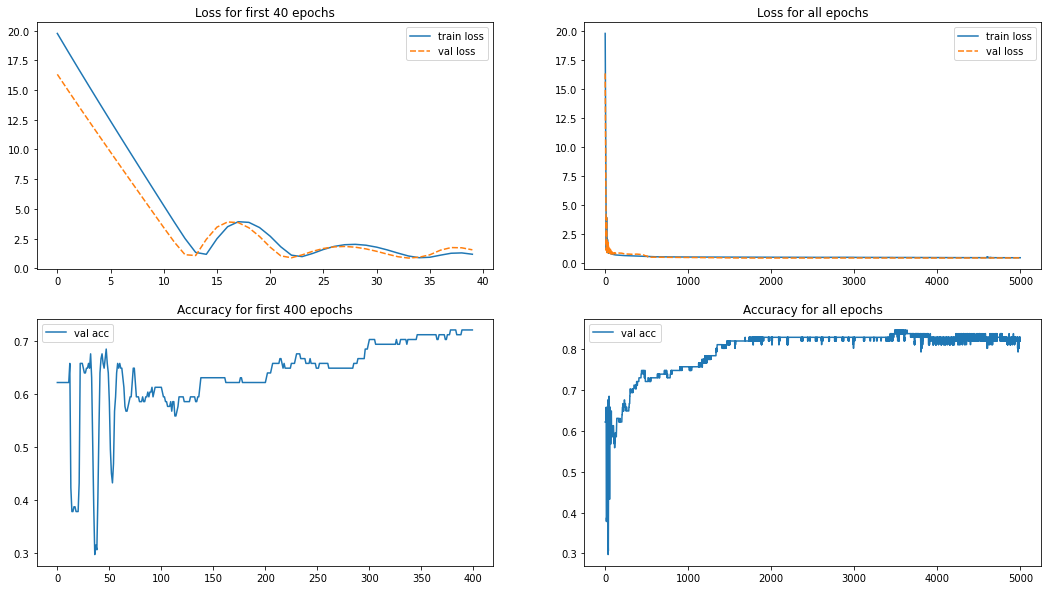

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the results
fig, ax = plt.subplots(2, 2, figsize=(18, 10))  

# Loss for first 40 epochs
sns.lineplot(data=pd.DataFrame({'train loss': train_losses[:40], 'val loss': val_losses[:40]}), ax=ax[0][0])
ax[0][0].set_title('Loss for first 40 epochs')

# Loss for first all epochs
sns.lineplot(data=pd.DataFrame({'train loss': train_losses, 'val loss': val_losses}), ax=ax[0][1])
ax[0][1].set_title('Loss for all epochs')

# Acc for first 400 epochs
sns.lineplot(data=pd.DataFrame({'val acc': val_accs[:400]}), ax=ax[1][0])
ax[1][0].set_title('Accuracy for first 400 epochs')

# Acc for first all epochs
sns.lineplot(data=pd.DataFrame({'val acc': val_accs}), ax=ax[1][1])
ax[1][1].set_title('Accuracy for all epochs')

## The end

If you have made it all the way here successfully, congratulations! 🎉 

You have implemented your own GCN and tested it on a node classification task, and a more challenging classification task over multiple graphs.

We hope you can use this knowledge to apply GCNs not only to the tasks described here, but other applications where data can be modeled as a graph.

If you are interested in applying graph neural networks to larger graphs, or try newer architectures, you can dive deeper into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), a library with fast implementations for a wide range of architectures. It also comes with custom code that takes care of aspects that you dealt with manually for this assignment, like a more efficient implementation of the adjacency matrix multiplication via message-passing methods, and Data Loaders that relieve you from having to build block diagonal sparse matrices.

You can also check the [Deep Graph Library](https://docs.dgl.ai/) another powerful library for deep learning on graphs which also integrates with other backends like TensorFlow.

# Grading (10pt)

- Question 1: 0.25pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.25pt 
- Question 5: 0.5pt 
- Question 6: 0.5pt 
- Question 7: 0.5pt 
- Question 8: 0.5pt 
- Question 9: 1.5pt 
- Question 10: 0.5pt 
- Question 11: 0.25pt 
- Question 12: 0.5pt 
- Question 13: 0.5pt 
- Question 14: 1pt
- Question 15: 1pt
- Question 16: 1.5pt